# Introduction

All following script is used in determining the radial velocity given reduced and normalized spectral data (wavelengths & counts) in a .fits file with the wavelengths in the first column and the counts in the second column. You also must include HJD in header labeled as 'HJD'. 

Info in final plots can be easily saved using astropy.io.fits or similar packages as needed.

Radial velocity is determined by fitting two ploynomial curves to the walls of an emission, then taking the bisector at fixed heights. The average of these two wavelengths is taken and converted to km s^-1 and plotted as counts vs radial velocity for every day. The most appropriate range of averages are then averaged, producing a singular data point per day, which are then plotted as radial velocity versus time.

The script is commented throughout for ease of use. However, for the most part only the section titled 'Variable To Change' should require editting, with the exceptions being noted in this section as well.

# Load All Necessary Packages

In [1]:
import matplotlib.pyplot as plt                       #used for creating and labeling plots
from matplotlib.legend_handler import HandlerLine2D   #used for creating legends in plots and visually identifying data
import numpy as np                                    #used for creating and handling arrays, and performing polynomial fits
import astropy.io.fits as fits                        #used for loading in .fits files

# Variables To Change

In [2]:
    #Set variable 'filenames' to a list of the names of the file you want to read in, be sure to write the name as a string.
filenames=['H4861NormPlot200103','H4861NormPlot200115','H4861NormPlot200130','H4861NormPlot200210','H4861NormPlot200220','H4861NormPlot200301','H4861NormPlot200311']
    #Set variable 'file' to the portion of the name of the files you wish to read in which is consistent for each file.
file='H4861NormPlot'


    #Set variable for which day you would like debug plots to display. This value will not effect end results.
day=0


    #Set boundary so that you have two sections, one for each side of the emission. 
    #This can be an approximation and you can adjust it at the begining of the section 'Take Sides of Peak'
#section 1
wavemin1=4855.8                  #desired range min
wavemax1=4857.7                  #desired range max

#section 2
wavemin2=4863.0                  #desired range min
wavemax2=4865.1                  #desired range max

    #Set degree of polynomial fit which wil be fitted to the sides of the emission
nDeg=4

    #Set range of heights(counts) near the center of the emission to take velocities at.
    #This can be an approximation and you can adjust it at the begining of the section 'Find Corresponding Velocities to Fixed Heights'
hStart=4                       #lowest height the radial vel is taken at
hStop=8                        #highest point the radial vel is taken at
hStep=0.1                      #step/gap between heights radial vel is taken at

    #Set range of heights(counts) to average velocities between. This should be a very rough approximation and adjusted 
    #at the begining of section 'Plot Avg Velocity for Each Day' and determined using the plots from 'Plot Rad Vel vs Counts'
final_height_min=5                                     #min height associated with range of velocities to be averaged together
final_height_max=6                                     #max height associated with range of velocities to be averaged together

    #Set constants appropriately
period=2022.7
HJD_0=2452819.2

# Read in Data

Read in the data and save necessary values for later use.
Make sure your file contains the wavelength in the first column and the counts in the second.

In [3]:
HJD=[]                                       #make list for HJDs
wavelengths=[]                               #make list for all wavelengths (will become a nested list)
counts=[]                                    #make list for all counts      (will become a nested list)

for i in range(len(filenames)):  
    hdu = fits.open(filenames[i]+'.fits')    #open file
    image = hdu[0]                           #retrieve all info
    header = image.header                    #retrieve header info
    data = image.data                        #retrieve all data

    wavelengths.append(data[:,0])      #add wavelenths to appropriate master list
    counts.append(data[:,1])           #add counts to appropriate master list
    HJD.append(header['HJD'])                #add HJD to appropriate master list

Create plots and print length of data to make sure you are on the right track

you are using 7 days of data


Text(0.5, 1.0, 'Day 0')

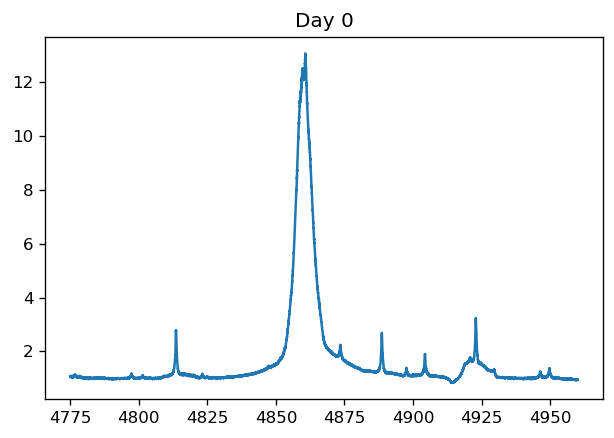

In [4]:
print('you are using '+ str(len(filenames))+' days of data') #print amount of days being used

plt.figure(dpi = 120)                        #adjust plot size/quality
plt.plot(wavelengths[day], counts[day])      #print desired day's plot
plt.title('Day '+str(day))                   #give plot a title

# Take Sides of Peak

Adjust wavelengths min/max to fit your needs by using the plt.xlim and plt.ylim to find the approximate wavelengths of the walls of the peak. The important thing here is that you have only wavelengths cooresponding to the wall, and have an area roughly around the middle region.

The risk of including wavelengths too close to the peak or continuum is that the polynomial fit may not be as accurate. It is also good to check a few different days by changing the 'day' variable to ensure the area you choose works for all of your data.

Things that end in 1 are the left side of the emission, things that end in 2 are the right side of the emission.

(4855.8, 4857.7)

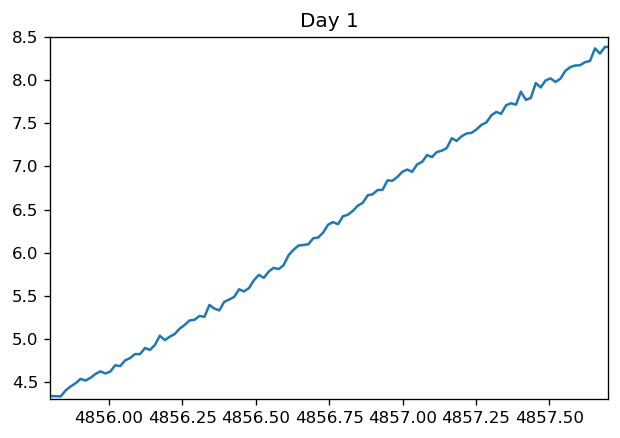

In [5]:
day = 1                                      #Set variable for which day you would like to see

plt.figure(dpi = 120)                        #adjust plot size/quality
plt.plot(wavelengths[day], counts[day])      #print desired day's plot
plt.title('Day '+str(day))                   #give plot a title

plt.ylim(4.3,8.5)                            #restrict y axis (adjusted to find walls of peak)
plt.xlim(4855.8, 4857.7)                       #restrict x axis (adjusted to find walls of peak)

Edit the following cell to match the min/max you just found.

In [6]:
#section 1
wavemin1=wavemin1                #desired range min
wavemax1=wavemax1                #desired range max

#section 2
wavemin2=wavemin2                #desired range min
wavemax2=wavemax2                #desired range max

Following cell should not need to be editted. This cell makes new lists of the wavelengths/counts between the min and max you just provided, these lists will be used later.

In [7]:
#define lists to add desired wavelengths/counts to
list_counts1 = []
list_wave1 = []
list_counts2 = []
list_wave2 = []

###

#make a list of wavelengths from a single day
for i in range(len(wavelengths)):
    wave_temp = wavelengths[i]            #wavelegths for this day
    wave_tempArray = np.array(wave_temp)  #make into array for later use
    counts_temp = counts[i]               #counts for this day
    print(i)                              #for debugging, useful to ensure program is working/hasn't frozen for larger files. Can be deleted for speed

#make list of terms of desired wavelengths in section 1
    temp_listwave = []                    #define list to temp store wavelengths before moving them to a nested list
    temp_listcounts = []                  #define list to temp store counts before moving them to a nested list
    
    indeces1 = (np.logical_and(wavemin1 <= wave_tempArray, wave_tempArray <= wavemax1)).nonzero()  #get array of the indeces of all wavelengths in section 1 for this day

    list_index1= list(indeces1[0])        #make indeces into list
    minIndex1 = min(list_index1)          #save starting position as variable          
    maxIndex1 = max(list_index1)          #save end position as variable

    #Make list of wavelengths in section 1                        
    for n in range(minIndex1, maxIndex1):
        temp_listwave.append(wave_temp[n]) #save to list

    #Make list of counts in section 1                             
    for n in range(minIndex1, maxIndex1):  
        temp_listcounts.append(counts_temp[n]) #save to list
    
    #Put all desired data from one day into section 1's nested list
    list_wave1.append(temp_listwave)
    list_counts1.append(temp_listcounts)
    
###
#make list of terms of desired wavelengths in section 2
    temp_listwave = []                    #define list to temp store wavelengths before moving them to a nested list
    temp_listcounts = []                  #define list to temp store counts before moving them to a nested list
    
    indeces2 = (np.logical_and(wavemin2 <= wave_tempArray, wave_tempArray <= wavemax2)).nonzero() #get array of the indeces of all wavelengths in section 2 for this day
   
    list_index2 = list(indeces2[0])       #make indeces into list
    minIndex2 = min(list_index2)          #save starting position as variable  
    maxIndex2 = max(list_index2)          #save end position as variable

    #Make list of wavelengths in section 2                        
    for n in range(minIndex2, maxIndex2):
        temp_listwave.append(wave_temp[n]) #save to list

    #Make list of counts in section 2                             
    for n in range(minIndex2, maxIndex2):  
        temp_listcounts.append(counts_temp[n]) #save to list
    
###
    #Put all desired data from one day section 2's nested list
    list_wave2.append(temp_listwave)
    list_counts2.append(temp_listcounts)
    
#change the nested lists into array for future use
array_wave1 = np.array(list_wave1)
array_count1 = np.array(list_counts1)
array_wave2 = np.array(list_wave2)
array_count2 = np.array(list_counts2)

0
1
2
3
4
5
6


Plot to make sure the desired sections of the plot were taken and that everything still looks good. Plot should show full spectra with the sides of the emission highlighted

Text(0.5, 1.0, 'emission w/ highlighted regions around middle')

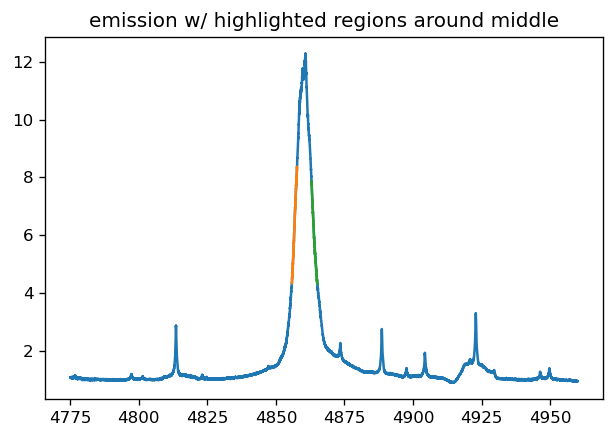

In [8]:
plt.figure(dpi = 120)                       #adjust plot's size
plt.plot(wavelengths[day],counts[day])      #plot spectra
plt.plot(list_wave1[day],list_counts1[day]) #plot/highlight data in section 1(right side of peak)
plt.plot(list_wave2[day],list_counts2[day]) #plot/highlight data in section 2(left side of peak)
plt.title('emission w/ highlighted regions around middle') #label

# Find Polynomial Fits

Fits a polynomial to sections created in previous section

In [9]:
#make list to store values by day
poly=[]
counts_fit=[]
wave_fit=[]

#run through each day and perform fit
for n in range(len(wavelengths)):
    #First Section (Left Side)
    coefficients1 = np.polyfit(list_counts1[n], list_wave1[n], nDeg)    #Do a nth deg polynomial fit and record coefficients to a list called coefficients1.
    poly1 = np.poly1d(coefficients1)                                    #Create an equation of nth deg poly with coefficients for fit
    counts_fit1 = np.linspace(list_counts1[n][0], list_counts1[n][-1])  #Create list of all all intergers from min to max counts
    wave_fit1 = poly1(counts_fit1)                                      #Create a list of corresponding wavelengths for the new list of counts from the fit equation

    #Second Section (Right Side)
    coefficients2 = np.polyfit(list_counts2[n], list_wave2[n], nDeg)    #Do a nth deg polynomial fit and record coefficients to a list called coefficients2.
    poly2 = np.poly1d(coefficients2)                                    #Create an equation of nth deg poly with coefficients for fit
    counts_fit2 = np.linspace(list_counts2[n][0], list_counts2[n][-1])  #Create list of all all intergers from min to max counts
    wave_fit2 = poly2(counts_fit2)                                      #Create a list of corresponding wavelengths for the new list of counts from the fit equation

    #Save Fit Equation, Count Range, and Fitted Wavelengths to Lists
    poly.append([poly1,poly2])
    counts_fit.append([counts_fit1,counts_fit2])
    wave_fit.append([wave_fit1,wave_fit2])

Plot to make sure fit looks good. Should show data points from sides of peak with a fitted curve going through each.

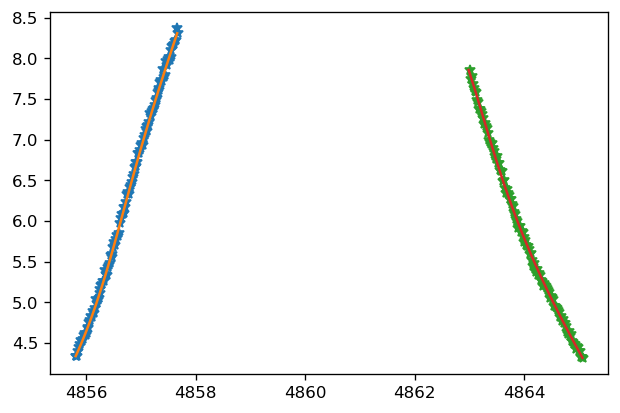

In [10]:
plt.figure(dpi = 120)
plt.plot(list_wave1[day],list_counts1[day], "*", wave_fit[day][0], counts_fit[day][0])
plt.plot(list_wave2[day],list_counts2[day], "*", wave_fit[day][1], counts_fit[day][1])

# Find Corresponding Velocity to Fixed Heights

Averages wavelengths at provided fixed heights and convert into km for radial velocity. 

Remove the first hashtag in each line in the first cell to adjust the height range as needed, remember that its good to over approximate here as you will choose a smaller section to average into your final radial velocity later.

In [11]:
#hStart=4   #set to the lowest height the radial vel is taken at
#hStop=8    #set to the highest point the radial vel is taken at
#hStep=0.1  #set to the step/gap between heights radial vel is taken at

In [12]:
radvel = []                                               #make list for all radial velocities
Hwave = []                                                #Make list for all wavelengths associated with predetermined heights
height=list(np.arange(hStart,hStop,hStep))                #Make list for all heights to take wavelengths

for i in range(len(wavelengths)):

    #Use fit to interpolate wavelengths
    Hwave_temp=[]                                         #Create/clear temp list for wavelengths needed for calculations
    radvel_temp=[]                                        #Create/clear radial velocity temp list
    for n in range(len(height)):
        Hwave_temp.append([poly[i][0](height[n]),poly[i][1](height[n])]) #add wavelength associated with heights to temp list for calculations (using temp list keeps code cleaner)
    
    #Calculate velocity for each height
    for c in range(len(Hwave_temp)):
        vel_A=(Hwave_temp[c][1]+Hwave_temp[c][0])/2       #Compute radvel in A
        vel_km=(vel_A-4861.35)/4861.35*299792.458         #Convert radvel to km
        radvel_temp.append(vel_km)                        #Append radvel in km to list
    
    #Add to nested lists
    radvel.append(radvel_temp)                            #Append radvel in km as a nested list
    Hwave.append(Hwave_temp)                              #add to permanent list for record keeping(as nested list)

Plot to make sure wavelengths and heights correspond appropriately. All the red dots (representing the point the emission overlaps one of the given heights) should be directly on the emission.

Text(0.5, 1.0, 'Fixed Heights on Spectra')

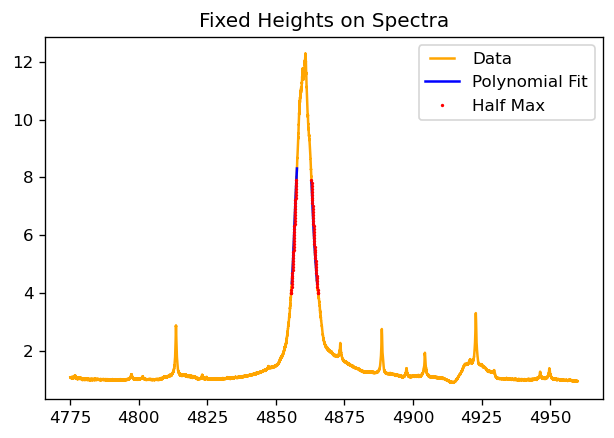

In [13]:
plt.figure(dpi = 120)                                                                               #adjust size of plot

Data, = plt.plot(wavelengths[day], counts[day], color = 'orange', label='Data')     #Plot data polynomial is being fitted to
PFit1, = plt.plot(wave_fit[day][0], counts_fit[day][0], color = 'blue', label='Polynomial Fit')     #Plot Polynomial fit
PFit2, = plt.plot(wave_fit[day][1], counts_fit[day][1], color = 'blue')                             #Plot Polynomial fit
H_wave, = plt.plot(Hwave[day][0],([height[0],height[0]]),'.',color='red',markersize=2, label='Half Max')         #Plot first height point

#loop through all provided fixed heights and plot corresponding fixed height point
for n in range(len(height)):
    H_wave,=plt.plot(Hwave[day][n],([height[n],height[n]]),'.',color='red',markersize=2)                         #Plot nth height point

plt.legend(handler_map={Data: HandlerLine2D(numpoints=4)})                                          #Make legend
plt.title('Fixed Heights on Spectra')                                                               #add title

# Plot for all days

Plot all days to check that everything looks good so far. This section is not critcal to any following sections, but highly reccomended for debugging.

For larger files you may want to save images to make them into .gifs for easier comparison. Images can be saved as .png by remove the first hashtag the last line.

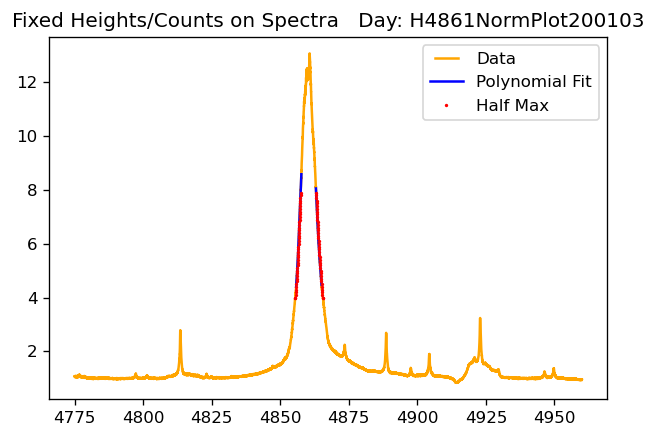

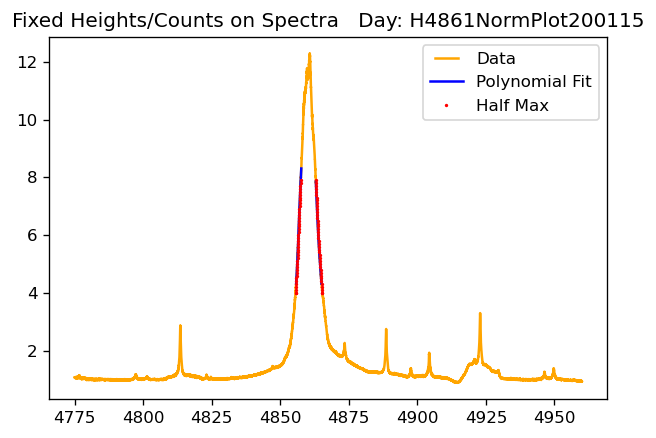

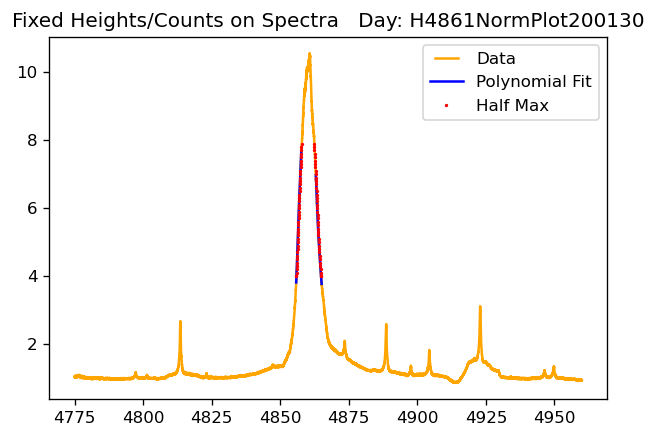

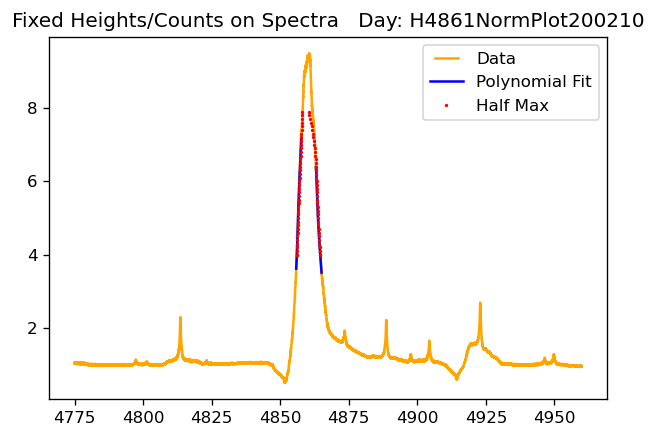

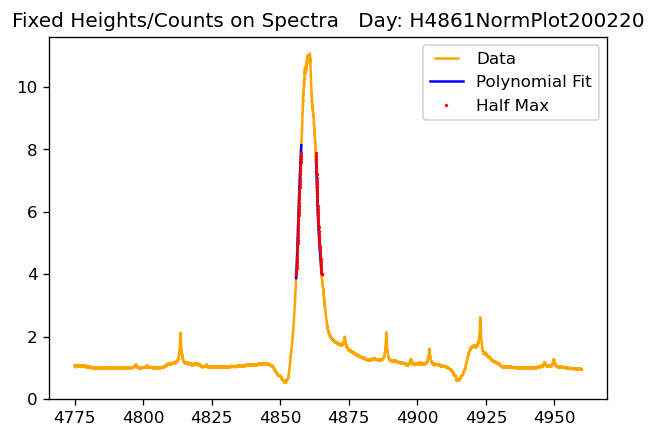

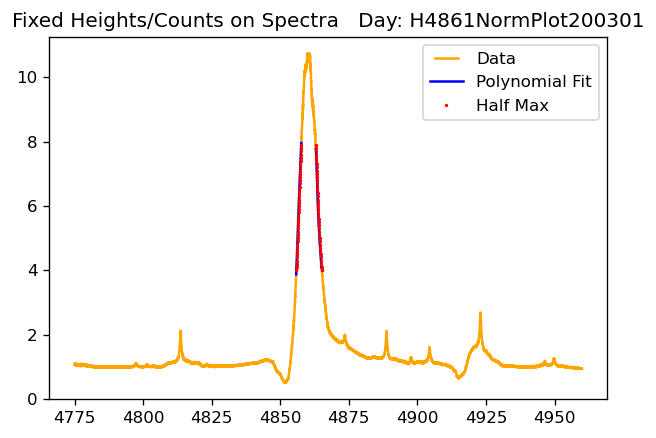

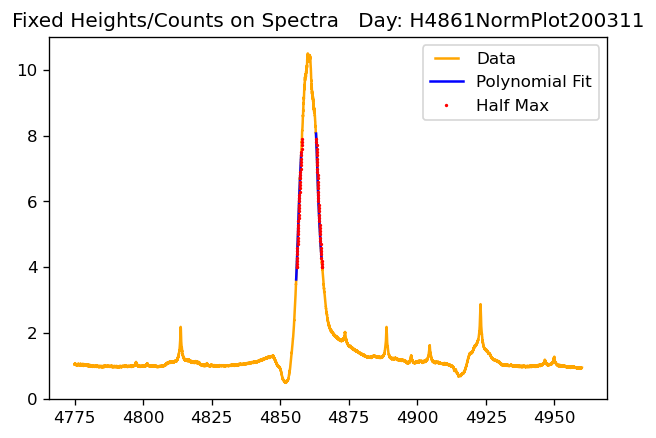

In [14]:
#Plot to debug
for i in range(len(wavelengths)):
    plt.figure(dpi = 120)                                                           #adjust size of plot

    Data, = plt.plot(wavelengths[i], counts[i], color = 'orange', label='Data')     #Plot data polynomial is being fitted to
    PFit1, = plt.plot(wave_fit[i][0], counts_fit[i][0], color = 'blue', label='Polynomial Fit') #Plot Polynomial fit
    PFit2, = plt.plot(wave_fit[i][1], counts_fit[i][1], color = 'blue')             #Plot Polynomial fit
    H_wave, = plt.plot(Hwave[i][0],([height[0],height[0]]),'.',color='red',markersize=2, label='Half Max')   #Plot first height point

    #loop through all provided fixed heights and plot corresponding fixed height point
    for n in range(len(height)):
        H_wave,=plt.plot(Hwave[i][n],([height[n],height[n]]),'.',color='red',markersize=2)       #Plot nth height point


    plt.legend(handler_map={Data: HandlerLine2D(numpoints=4)})                      #Make legend
    plt.title('Fixed Heights/Counts on Spectra   Day: '+filenames[i])                #add title

    #plt.savefig('hBetaFit'+(i)+'.png')                                              #save as PNGs

# Plot Rad Vel vs Counts

Simiarly to previous section, this saves each image so you can either make a .gif or compare by skimming through the images to find the most appropriate range of heights to use. 

For larger files you may want to save images to make them into .gifs for easier comparison. Images can be saved as .png by remove the first hashtag the last line.

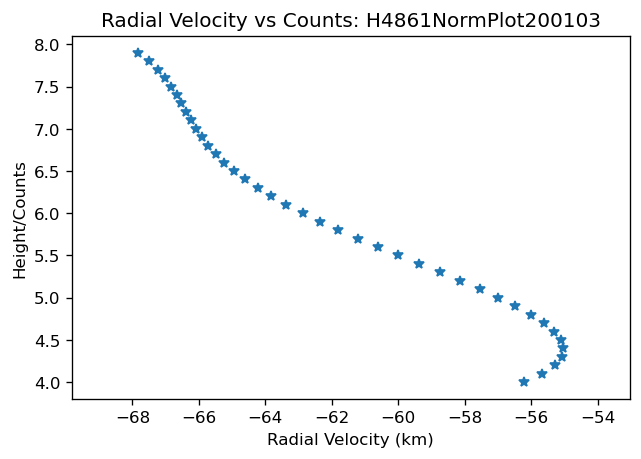

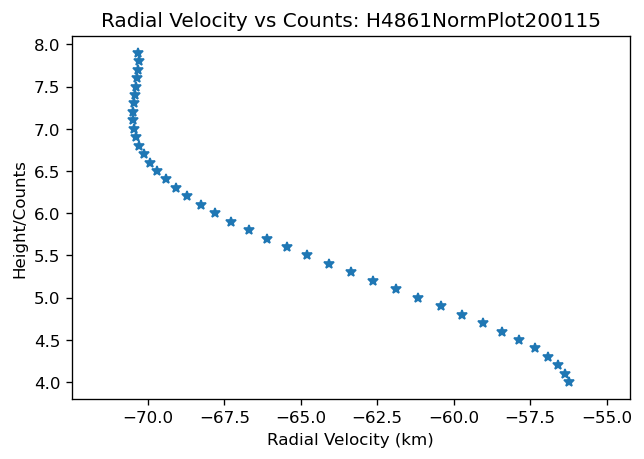

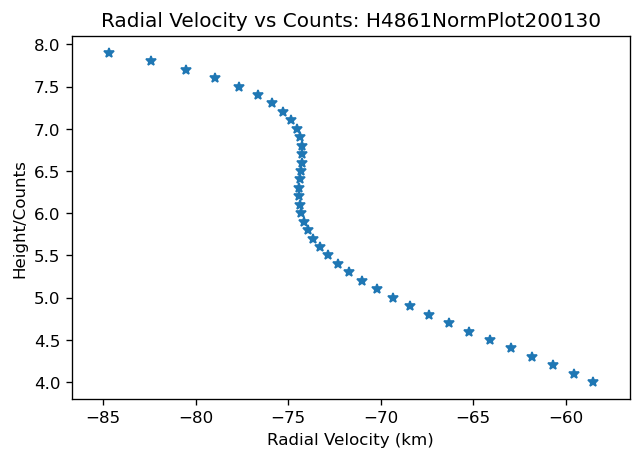

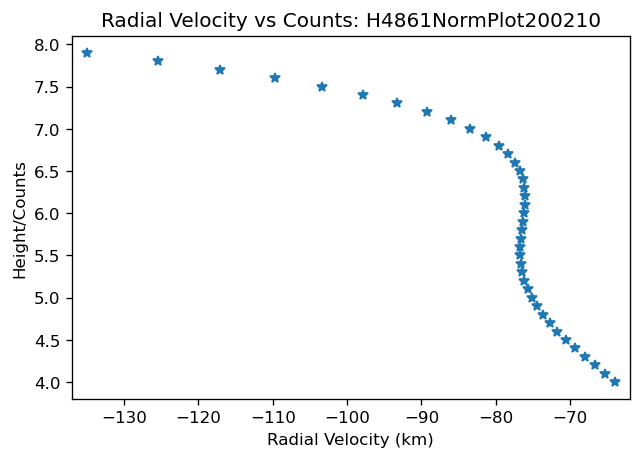

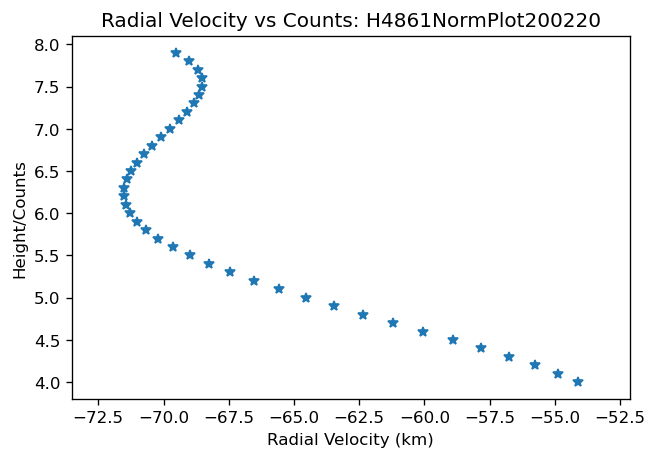

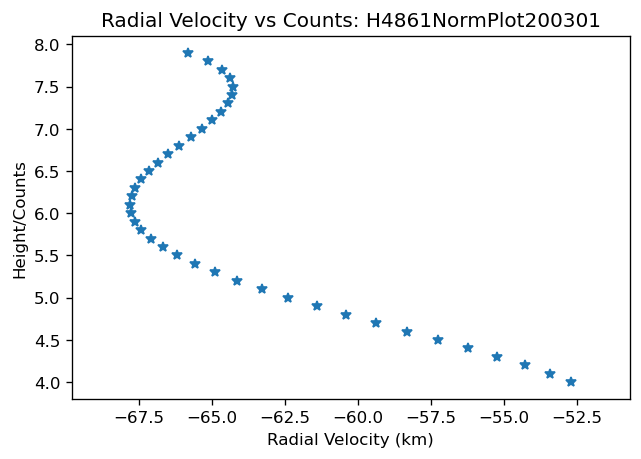

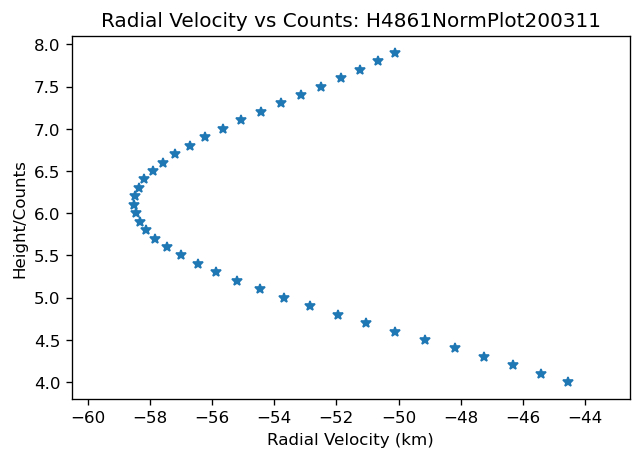

In [15]:
for i in range(len(filenames)):                                 #loop through each day
    plt.figure(dpi = 120)                                  #adjust size of plot
    plt.plot(radvel[i],height,'*')                         #plot radvel vs height for appropriate day
    plt.xlim(min(radvel[i])-2,max(radvel[i])+2)                      #keep plot dimensions static for easier comparison
    plt.title('Radial Velocity vs Counts: '+ filenames[i])  #make title
    plt.xlabel('Radial Velocity (km)')                     #label x axis
    plt.ylabel('Height/Counts')                #label y axis
    
    #plt.savefig('RadVel_Time'+str(i)+'.png')               #save as png    

# Plot Avg Velocity for Each Day

Averages together the most appropriate range of velocities to get one velocity per day and creates a plot of all velocities.

Set the range of velocities you want averaged by denoting the heights(counts) they are between. Remove the first hashtag on each line and set the variable to the appropriate value.

In [16]:
final_height_min=final_height_min                                     #min height associated with range of velocities to be averaged together
final_height_max=final_height_max                                     #max height associated with range of velocities to be averaged together

Finds indeces inorder to call appropriate velocities

In [17]:
hIndeces = (np.logical_and(final_height_min <= np.array(height), np.array(height) <= final_height_max)).nonzero() #get array of the indeces of all desired heights
print(hIndeces[0])
list_hIndex = list(hIndeces[0])       #make indeces into list
min_hIndex = min(list_hIndex)         #save starting position as variable  
max_hIndex = max(list_hIndex)         #save end position as variable

[11 12 13 14 15 16 17 18 19 20]


Calculates average velocity and appends it to a list

In [18]:
avgvel=[]                      #Create list to append averaged velocities to

for i in range(len(filenames)):     #loops through each day
    temp_sumvel=0              #resets temporary variable used in calculation
    for n in range(final_height_min,final_height_max): #cycles through each denoted velocity in that day
        temp_sumvel=temp_sumvel+radvel[i][n]           #sums velocities
        temp_avgvel=temp_sumvel/10  #averages summed velocities
    avgvel.append(temp_avgvel) #appends average velocity to list

Plots averaged velocities vs HJD and saves as png

Text(0, 0.5, 'velocity km s^-1')

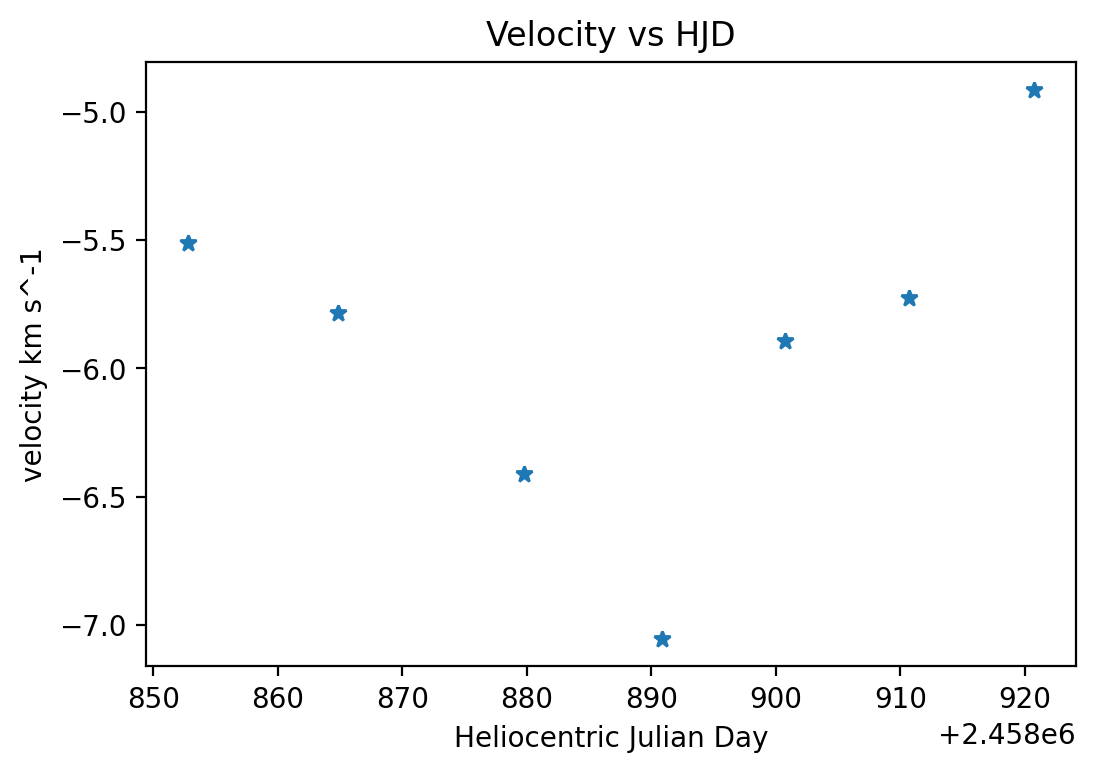

In [19]:
plt.figure(dpi = 200)                  #adjust size of plot
plt.plot(HJD,avgvel,'*')               #plots vel vs HJD
plt.title('Velocity vs HJD')           #tiles plot
plt.xlabel('Heliocentric Julian Day')  #label x-axis
plt.ylabel('velocity km s^-1')            #label y-axis

Calculates phase and plots averaged velocity vs phase

Text(0, 0.5, 'velocity km s^-1')

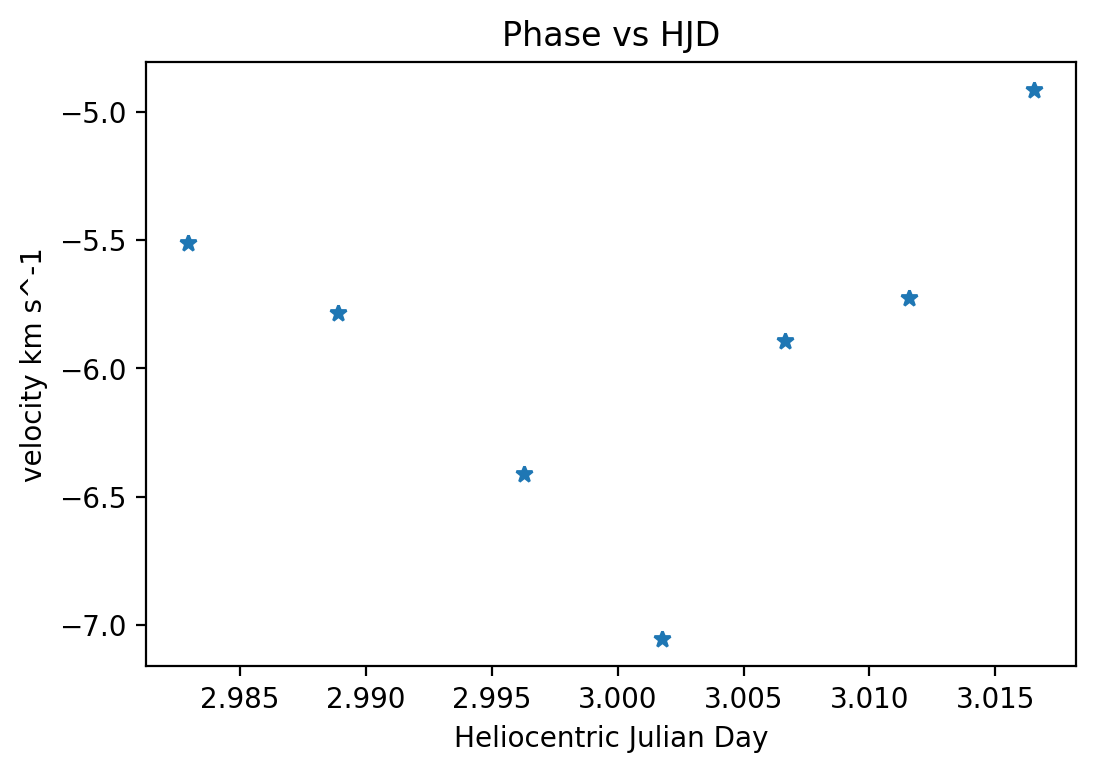

In [20]:
phaselist=[]                            #list to save all relevant phases to

for i in range(len(HJD)):               #cycle through each day to find phase for that day
    phase = (HJD[i]-HJD_0)/period       #calculate phase of day by dividing by period
    phaselist.append(phase)             #save phase to list

plt.figure(dpi = 200)                  #adjust size of plot
plt.plot(phaselist,avgvel,'*')         #plots velocity vs phase
plt.title('Phase vs HJD')              #tiles plot
plt.xlabel('Heliocentric Julian Day')  #label x-axis
plt.ylabel('velocity km s^-1')         #label y-axis